Testing BurgersPDE Ground Truth (Cole-Hopf for u0 = -sin(pi*x))...
Using device: cuda

Calculating GT for t=0.000, nu=0.0010 (kappa=1000.00)
  u_gt min: -1.000, max: 1.000, mean: -0.000

Calculating GT for t=0.250, nu=0.0010 (kappa=1000.00)
  u_gt min: -0.998, max: 0.998, mean: -0.000

Calculating GT for t=0.500, nu=0.0010 (kappa=1000.00)
  u_gt min: -0.995, max: 0.995, mean: -0.000

Calculating GT for t=0.750, nu=0.0010 (kappa=1000.00)
  u_gt min: -0.870, max: 0.870, mean: -0.000

Calculating GT for t=0.990, nu=0.0010 (kappa=1000.00)
  u_gt min: -0.733, max: 0.733, mean: -0.000


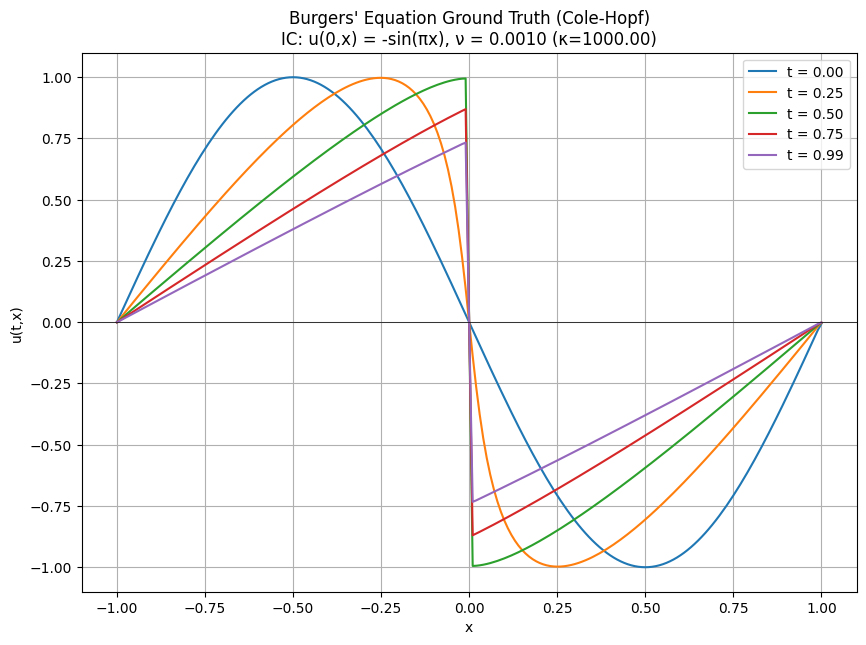

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import cache 
from torch.quasirandom import SobolEngine
from abc import ABC, abstractmethod
from typing import List, Dict, Tuple, Optional, Union
from scipy.interpolate import RegularGridInterpolator
from scipy.fft import fft, ifft, fftfreq
import os

def solve_burgers_spectral_rk4_simple(
    nu: float, 
    L_domain: float, 
    Nx: int, 
    t_final: float, 
    Nt_storage: int, 
    u0_func: callable,
    verbose: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Solves Burgers' u_t + u*u_x = nu*u_xx with IC u(0,x)=u0_func(x)
    and periodic BCs on x in [-L_domain/2, L_domain/2].
    Uses a simplified spectral method (FFT) for spatial derivatives and RK4 for time integration.
    WARNING: Basic implementation without robust de-aliasing or adaptive time-stepping.
    """
    if verbose:
        print(f"Solving Burgers numerically (Simplified Spectral RK4) for nu = {nu:.5e} up to t = {t_final}")

    # Define Spatial Grid (shifted to [0, L_domain] for FFT, then shifted back)
    dx = L_domain / Nx
    x_fft_grid = np.linspace(0, L_domain - dx, Nx, endpoint=False) 
    x_physical_grid = x_fft_grid - L_domain / 2.0 # For IC and output

    # Set Initial Condition
    u_current = u0_func(x_physical_grid)

    # Time Stepping Parameters
    t_coords_storage = np.linspace(0, t_final, Nt_storage)
    u_solution_storage = np.zeros((Nt_storage, Nx))
    u_solution_storage[0, :] = u_current.copy()
    
    # Wavenumbers for FFT derivatives (for domain of length L_domain)
    k_wavenumbers = 2 * np.pi * fftfreq(Nx, d=dx) # These are k = 2*pi*n/L

    # Estimate dt based on a simplified CFL
    # This is a heuristic and might need tuning or adaptive dt for robustness
    max_u_abs = np.max(np.abs(u_current)) + 1e-6 # Add epsilon to avoid division by zero
    dt_adv = 0.5 * dx / max_u_abs if max_u_abs > 1e-6 else float('inf')
    dt_diff = 0.25 * dx**2 / (nu + 1e-9) if nu > 1e-9 else float('inf') # Add epsilon for nu
    dt = min(dt_adv, dt_diff, 0.001) # Cap dt, and ensure it's positive
    if dt <= 0: dt = 1e-5 # Ensure dt is positive if heuristics fail
    
    num_total_steps = int(np.ceil(t_final / dt))
    if num_total_steps == 0 and t_final > 0: num_total_steps = 1 # Ensure at least one step if t_final > 0
    dt = t_final / num_total_steps if num_total_steps > 0 else 0 # Adjust dt to hit t_final exactly

    if verbose:
        print(f"  Nx={Nx}, Nt_storage={Nt_storage}, Num_total_steps={num_total_steps}, dt={dt:.3e}")

    current_t = 0.0
    storage_idx = 1

    def spectral_rhs(u_field, k_spec, nu_spec):
        u_hat = fft(u_field)
        ux_hat = 1j * k_spec * u_hat
        uxx_hat = (1j * k_spec)**2 * u_hat
        
        ux_field = np.real(ifft(ux_hat))
        uxx_field = np.real(ifft(uxx_hat))
        
        # Nonlinear term u*u_x - basic, no de-aliasing
        nonlinear_term = u_field * ux_field 
        return -nonlinear_term + nu_spec * uxx_field

    # --- Time-stepping loop (RK4) ---
    for step in range(1, num_total_steps + 1):
        k1 = dt * spectral_rhs(u_current, k_wavenumbers, nu)
        k2 = dt * spectral_rhs(u_current + 0.5 * k1, k_wavenumbers, nu)
        k3 = dt * spectral_rhs(u_current + 0.5 * k2, k_wavenumbers, nu)
        k4 = dt * spectral_rhs(u_current + k3, k_wavenumbers, nu)
        
        u_next = u_current + (k1 + 2*k2 + 2*k3 + k4) / 6.0
        u_current = u_next
        current_t += dt

        if storage_idx < Nt_storage and current_t >= t_coords_storage[storage_idx]:
            u_solution_storage[storage_idx, :] = u_current.copy()
            storage_idx += 1
        
        if verbose and step % (max(1,num_total_steps // 20)) == 0: # Progress print
             print(f"  Step {step}/{num_total_steps}, t={current_t:.3f}, max|u|={np.max(np.abs(u_current)):.3f}", end='\r')
    
    if verbose: print("\nNumerical solution finished.")
    
    # Ensure final time point is stored
    if storage_idx < Nt_storage and abs(current_t - t_coords_storage[-1]) < 1.5*dt : # If close enough
         u_solution_storage[-1, :] = u_current.copy()
    elif storage_idx == Nt_storage and abs(current_t - t_coords_storage[-1]) > 1.5*dt: # Ensure last point is there
        print("Warning: Final time point might not be perfectly aligned with storage.")
        # Could interpolate here if needed, but for simplicity, just store last computed step if close
        if abs(t_coords_storage[-1] - current_t + dt) < dt : # If the last step was the one before final storage point
             u_solution_storage[-1, :] = u_current.copy()


    return t_coords_storage, x_physical_grid, u_solution_storage


class PDEProblem(ABC):
    def __init__(
            self,
            name: str,
            input_vars: List[str] = ['x'],
            output_vars: List[str] = ['u'],
            time_var: Optional[str] = None,
            kappa_name: str = "kappa",
            default_kappa_value: float = 1.0
        ):
        self.name: str = name
        self.input_vars: List[str] = sorted(list(set(input_vars)))
        self.output_vars: List[str] = output_vars
        self.time_var: Optional[str] = time_var
        self.output_dim: int = len(self.output_vars)
        self.spatial_domain_dim: int = len(self.input_vars) - (1 if time_var else 0)
        self.time_dependent: bool = bool(time_var)
        self.kappa_name: str = kappa_name
        self.default_kappa_value: float = default_kappa_value
    @abstractmethod
    def get_domain_bounds(self) -> Dict[str, Tuple[float, float]]: pass
    @abstractmethod
    def get_ground_truth(self,inputs: Dict[str, torch.Tensor],kappa_value: float) -> Optional[torch.Tensor]: pass
    def get_collocation_points(self,
                               num_points: int,
                               kappa_value: float,
                               device: Union[str, torch.device] = 'cpu',
                               strategy: str = 'uniform') -> Dict[str, torch.Tensor]:
        domain_bounds = self.get_domain_bounds()
        inputs = {}

        if strategy == 'sobol':
            num_input_dims_for_sampling = len(self.input_vars)
            if num_input_dims_for_sampling == 0: # Should not happen for collocation
                 return {}
            sobol = SobolEngine(dimension=num_input_dims_for_sampling, scramble=True)
            # Move Sobol samples to target device after generation
            samples_0_1 = sobol.draw(num_points).to(device)

        for i, var_name in enumerate(self.input_vars):
            if var_name not in domain_bounds:
                raise ValueError(f"Domain bounds not defined for variable: {var_name}")
            var_min, var_max = domain_bounds[var_name]

            if strategy == 'uniform':
                samples_var = torch.rand(num_points, 1, device=device) * (var_max - var_min) + var_min
            elif strategy == 'sobol':
                samples_var = samples_0_1[:, i:i+1] * (var_max - var_min) + var_min
            else:
                raise NotImplementedError(f"Collocation sampling strategy '{strategy}' not implemented for variable '{var_name}'.")

            inputs[var_name] = samples_var.requires_grad_(True)
        return inputs
    
    

class BurgersPDE(PDEProblem):
    def __init__(self, 
                 N_terms_fourier_gt=150, # Default for Cole-Hopf where it's stable
                 N_points_integrate_coeffs_gt=4096,
                 gt_data_path_template: Optional[str] = "burgers_gt_data/nu_{nu:.5e}.npz",
                 nu_threshold_numerical_gt: float = 0.025, # nu below which numerical GT is preferred
                 numerical_solver_Nx: int = 2048, # Nx for numerical solver
                 numerical_solver_Nt_storage: int = 201 # Nt for numerical solver
                 ):
        super().__init__(name="Burgers",
                         input_vars=['t', 'x'],
                         output_vars=['u'],
                         time_var='t',
                         kappa_name="1/nu",
                         default_kappa_value=100.0)
        self.N_terms_fourier_gt = N_terms_fourier_gt
        self.N_points_integrate_coeffs_gt = N_points_integrate_coeffs_gt
        self._cached_theta_coeffs = {} 
        self._cached_numerical_gt = {} # Cache for loaded numerical solutions / interpolators
        self.gt_data_path_template = gt_data_path_template
        self.nu_threshold_numerical_gt = nu_threshold_numerical_gt
        self.numerical_solver_Nx = numerical_solver_Nx
        self.numerical_solver_Nt_storage = numerical_solver_Nt_storage

    def get_domain_bounds(self) -> Dict[str, Tuple[float, float]]:
        return {'t': (0.0, 1.0), 'x': (-1.0, 1.0)}

    def _u0_func_for_gt(self, x_np: np.ndarray) -> np.ndarray:
        """Initial condition u(0,x) = -sin(pi*x) for ground truth solver."""
        return -np.sin(np.pi * x_np)

    def get_ground_truth(self, inputs: Dict[str, torch.Tensor],
                       kappa_value: float) -> Optional[torch.Tensor]:
        t_eval_torch = inputs['t']
        x_eval_torch = inputs['x']
        current_device = x_eval_torch.device

        if kappa_value == float('inf'): # nu = 0
             print("Warning: kappa_value is inf (nu=0). Numerical GT needed for inviscid. Returning NaN.")
             return torch.full_like(x_eval_torch, float('nan'))
        elif kappa_value <= 1e-9: # Effectively nu is extremely large
            nu = 1.0 / (kappa_value + 1e-12) # Avoid direct division by zero, make nu very large
            print(f"Warning: kappa_value ({kappa_value}) is very small, nu is very large ({nu:.2e}). "
                  "Using simplified GT (IC or zeros).")
            if torch.all(t_eval_torch < 1e-6):
                 return -torch.sin(torch.pi * x_eval_torch)
            return torch.zeros_like(x_eval_torch) # Solution diffuses to 0 for u0=-sin(pi*x) with periodic/zero BC
        else:
            nu = 1.0 / kappa_value

        if nu < self.nu_threshold_numerical_gt and self.gt_data_path_template:
            filename_nu_part = f"nu_{nu:.5e}".replace('.', 'p').replace('-', 'm') 
            base_dir = os.path.dirname(self.gt_data_path_template.format(nu=0.1)) 
            gt_file_path = os.path.join(base_dir, f"{filename_nu_part}.npz")
            
            cache_key_numerical = gt_file_path
            interp_func = self._cached_numerical_gt.get(cache_key_numerical)

            if interp_func is None:
                if os.path.exists(gt_file_path):
                    try:
                        data = np.load(gt_file_path)
                        t_solver_gt, x_solver_gt, u_solver_gt = data['t_coords_solver'], data['x_coords_solver'], data['u_solution_solver']
                        
                        t_solver_gt = t_solver_gt.astype(np.float64)
                        x_solver_gt = x_solver_gt.astype(np.float64)
                        u_solver_gt = u_solver_gt.astype(np.float64)

                        if not (np.all(np.diff(t_solver_gt) > 0) and np.all(np.diff(x_solver_gt) > 0)):
                            sort_t_idx = np.argsort(t_solver_gt); t_solver_gt = t_solver_gt[sort_t_idx]; u_solver_gt = u_solver_gt[sort_t_idx, :]
                            sort_x_idx = np.argsort(x_solver_gt); x_solver_gt = x_solver_gt[sort_x_idx]; u_solver_gt = u_solver_gt[:, sort_x_idx]
                            if not (np.all(np.diff(t_solver_gt) > 0) and np.all(np.diff(x_solver_gt) > 0)):
                                raise ValueError("Solver coordinates still not strictly ascending after sort attempt.")
                        
                        interp_func = RegularGridInterpolator(
                            (t_solver_gt, x_solver_gt), u_solver_gt,
                            method="linear", # "linear" is often more robust than default "cubic" at edges
                            bounds_error=False, fill_value=np.nan
                        )
                        self._cached_numerical_gt[cache_key_numerical] = interp_func
                    except Exception as e:
                        print(f"Error loading or creating interpolator for {gt_file_path}: {e}. Will attempt Fourier.")
                        interp_func = None
                else: 
                    print(f"Numerical GT file not found: {gt_file_path}. Generating it now...")
                    domain_b = self.get_domain_bounds()
                    L_domain_solver = domain_b['x'][1] - domain_b['x'][0]
                    
                    t_s, x_s, u_s = solve_burgers_spectral_rk4_simple(
                        nu=nu, L_domain=L_domain_solver, Nx=self.numerical_solver_Nx, 
                        t_final=domain_b['t'][1], Nt_storage=self.numerical_solver_Nt_storage,
                        u0_func=self._u0_func_for_gt
                    )
                    os.makedirs(os.path.dirname(gt_file_path), exist_ok=True)
                    np.savez_compressed(gt_file_path, 
                                        t_coords_solver=t_s.astype(np.float64), 
                                        x_coords_solver=x_s.astype(np.float64), 
                                        u_solution_solver=u_s.astype(np.float64)) # Save as float64
                    print(f"Saved newly generated GT to {gt_file_path}")
                    if not (np.all(np.diff(t_s) > 0) and np.all(np.diff(x_s) > 0)):
                         raise ValueError("Generated solver coordinates are not strictly ascending.")
                    interp_func = RegularGridInterpolator((t_s.astype(np.float64), x_s.astype(np.float64)), u_s.astype(np.float64),
                                                           method="linear", bounds_error=False, fill_value=np.nan)
                    self._cached_numerical_gt[cache_key_numerical] = interp_func

            if interp_func:
                t_eval_np = t_eval_torch.detach().cpu().numpy().astype(np.float64).flatten()
                x_eval_np = x_eval_torch.detach().cpu().numpy().astype(np.float64).flatten()

                # Clipping to handle potential floating point issues at boundaries
                solver_t_min, solver_t_max = interp_func.grid[0].min(), interp_func.grid[0].max()
                solver_x_min, solver_x_max = interp_func.grid[1].min(), interp_func.grid[1].max()
                
                epsilon_clip = 1e-9 # Small epsilon for clipping

                t_eval_np_clipped = np.clip(t_eval_np, solver_t_min + epsilon_clip, solver_t_max - epsilon_clip)
                x_eval_np_clipped = np.clip(x_eval_np, solver_x_min + epsilon_clip, solver_x_max - epsilon_clip)
                
                points_to_interpolate = np.stack((t_eval_np_clipped, x_eval_np_clipped), axis=-1)
                
                u_gt_np = interp_func(points_to_interpolate)
                
                nan_count = np.isnan(u_gt_np).sum()
                if nan_count > 0:
                    print(f"Warning: {nan_count} NaNs produced by interpolation for nu={nu} after clipping. "
                          f"Eval t range: [{t_eval_np.min():.4f}, {t_eval_np.max():.4f}] vs Solver t: [{solver_t_min:.4f}, {solver_t_max:.4f}]. "
                          f"Eval x range: [{x_eval_np.min():.4f}, {x_eval_np.max():.4f}] vs Solver x: [{solver_x_min:.4f}, {solver_x_max:.4f}].")
                
                return torch.tensor(u_gt_np, dtype=torch.float32, device=current_device).view_as(x_eval_torch)

        if nu >= self.nu_threshold_numerical_gt: 
            print(f"Using Fourier series (Cole-Hopf) for Burgers GT (nu={nu:.5e}).")
            # Adaptive N_fourier:
            current_N_fourier = self.N_terms_fourier_gt 
            if nu < 0.05 and current_N_fourier < 250: current_N_fourier = 250 
            elif nu < 0.1 and current_N_fourier < 150: current_N_fourier = 150
            
            c_n_0_real = self._compute_theta_0_coeffs(nu, device=current_device) # Uses self.N_terms_fourier_gt from instance

            x = x_eval_torch.view(-1, 1)
            t = t_eval_torch.view(-1, 1)
            
            # Ensure c_n_0_real has enough terms for current_N_fourier
            if c_n_0_real.shape[0] <= current_N_fourier:
                 print(f"Warning: c_n_0_real has {c_n_0_real.shape[0]-1} terms, but current_N_fourier is {current_N_fourier}. Using available terms.")
                 current_N_fourier = c_n_0_real.shape[0]-1

            n_vals = torch.arange(0, current_N_fourier + 1, device=current_device, dtype=torch.float32).view(1, -1)
            c_n_coeffs_for_sum = c_n_0_real[0 : current_N_fourier + 1].view(1, -1)

            theta_val = c_n_coeffs_for_sum[:, 0:1] 
            theta_x_val = torch.zeros_like(x)    

            if current_N_fourier > 0:
                n_pos_vals = n_vals[:, 1:]
                c_n_pos_coeffs = c_n_coeffs_for_sum[:, 1:]
                n_pi_x = n_pos_vals * np.pi * x
                exp_decay_arg = -nu * (n_pos_vals * np.pi)**2 * t
                exp_decay_arg = torch.clamp(exp_decay_arg, min=-70.0, max=70.0)
                exp_decay = torch.exp(exp_decay_arg)
                sum_terms_theta = 2.0 * c_n_pos_coeffs * torch.cos(n_pi_x) * exp_decay
                theta_val = theta_val + torch.sum(sum_terms_theta, dim=1, keepdim=True)
                sum_terms_theta_x = 2.0 * c_n_pos_coeffs * (-n_pos_vals * np.pi * torch.sin(n_pi_x)) * exp_decay
                theta_x_val = theta_x_val + torch.sum(sum_terms_theta_x, dim=1, keepdim=True)

            epsilon = 1e-12 
            theta_denominator = theta_val.clone()
            mask_small = torch.abs(theta_val) < epsilon
            theta_denominator[mask_small] = torch.sign(theta_val[mask_small]) * epsilon + epsilon * (theta_val[mask_small]==0)
            u_final = -2.0 * nu * (theta_x_val / theta_denominator)
            return u_final.view_as(x_eval_torch)
        
        print(f"Could not obtain ground truth for Burgers nu={nu:.5e} (after attempting numerical and Fourier).")
        return None # Fallback if all methods fail

def test_burgers_ground_truth():
    print("Testing BurgersPDE Ground Truth (Cole-Hopf for u0 = -sin(pi*x))...")
    
    # Parameters for the test
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # nu_value = 0.01 # Corresponds to kappa_value = 100
    # nu_value = 0.02  # Corresponds to kappa_value = 10
    # nu_value = 1.0 / (np.pi) # nu = 1/pi, often used in benchmarks, kappa = pi
    nu_value = 0.001 # kappa = 1000, very sharp shock

    kappa_test = 1.0 / nu_value
    
    # Increase N_terms_fourier for smaller nu (sharper shocks)
    # Increase N_points_integrate_coeffs for accuracy of Fourier coefficients
    burgers_problem = BurgersPDE(N_terms_fourier_gt=500, N_points_integrate_coeffs_gt=81092)
    
    # t_points_np = np.array([0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]) 
    t_points_np = np.array([0.0, 0.25, 0.5, 0.75, 0.99]) # Avoid t=1 if solution is very steep
    
    # Spatial grid for plotting
    nx_plot = 201
    x_plot_np = np.linspace(-1.0, 1.0, nx_plot)
    
    plt.figure(figsize=(10, 7))
    
    for t_val in t_points_np:
        t_tensor = torch.full((nx_plot, 1), t_val, dtype=torch.float32, device=device)
        x_tensor = torch.tensor(x_plot_np, dtype=torch.float32, device=device).unsqueeze(1)
        
        inputs_dict = {'t': t_tensor, 'x': x_tensor}
        
        print(f"\nCalculating GT for t={t_val:.3f}, nu={nu_value:.4f} (kappa={kappa_test:.2f})")
        u_gt = burgers_problem.get_ground_truth(inputs_dict, kappa_test)
        
        if u_gt is not None:
            u_gt_np = u_gt.cpu().numpy().squeeze()
            plt.plot(x_plot_np, u_gt_np, label=f't = {t_val:.2f}')
            print(f"  u_gt min: {u_gt_np.min():.3f}, max: {u_gt_np.max():.3f}, mean: {u_gt_np.mean():.3f}")
        else:
            print(f"  Ground truth returned None for t={t_val:.2f}")
            
    plt.title(f"Burgers' Equation Ground Truth (Cole-Hopf)\nIC: u(0,x) = -sin(πx), ν = {nu_value:.4f} (κ={kappa_test:.2f})")
    plt.xlabel("x")
    plt.ylabel("u(t,x)")
    plt.legend()
    plt.grid(True)
    plt.ylim(-1.1, 1.1) 
    plt.axhline(0, color='black', lw=0.5)
    plt.show()

if __name__ == '__main__':
    test_burgers_ground_truth()